In [1]:
import sys
sys.path.append('/vol/tensusers5/nhollain/s_clip_scripts')

from s_clip_scripts.data_loader import get_data, get_custom_data, TokenizedDataset, create_datainfo
from s_clip_scripts.tools import read_json, write_json
from collections import Counter
import pandas as pd
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
foo = Image.open('./images/Sydney_example.png') 
width, height = foo.size  # 1500 x 1500
 
# downsize the image with an ANTIALIAS filter (gives the highest quality)
new_width, new_height = round(width/4), round(height/4)
foo = foo.resize((new_width,new_height))
 
foo.save('./images/Sydney_example_scaled.png', quality=85)
foo.save('./images/Sydney_example_scaled_opt.png', optimize=True, quality=85)

In [3]:
print(os.listdir('./data'))

['sydney_captions', 'scicap_data.zip', 'polyvore', 'scicap', 'fashion200k', 'UCM_captions.zip', 'RSICD.zip', 'polyvore-images.tar.gz', 'RSICD', 'UCM', 'UCMerced_LandUse', 'WHU-RS19', 'RSSCN7', 'AID', 'NWPU-RESISC45', 'kaggle_simpsons_characters.zip', 'kaggle_simpsons_characters', 'polyvore_outfits.zip', 'polyvore_outfits', 'fashiongen', 'test', '.ipynb_checkpoints']


In [4]:
print(os.listdir('./data/RSICD'))

def load_captions(path: str, split: str = ''):
        captions = read_json(path)["images"]
        return [c['filename'] for c in captions if c["split"] == split or len(split) == 0]

def get_rsicd_counts(split = ''):
    data = load_captions('./data/RSICD/dataset_rsicd.json', split)
    
    classes = []
    path2class = {}
    
    class_dir = './data/RSICD/txtclasses_rsicd'
    for idx, fn in enumerate(sorted(os.listdir(class_dir))):
        classes.append(fn.split(".txt")[0])
        with open(os.path.join(class_dir, fn)) as f:
            for line in f.readlines():
                path2class[line.strip()] = idx

    path2class = {key:path2class[key] for key in data}
    path2class_lst = list(path2class.values())
    paths = list(path2class.keys())
    labels, counts = np.unique(path2class_lst, return_counts=True)
    return labels, counts, paths
    # plt.title('RSICD label counts ({})'.format(split))
    # plt.ylabel('Count')
    # plt.bar(labels, counts, align='center')
    # plt.xticks(labels, rotation = 90)
    # plt.show()
    # return paths

rsicd_train_labels, rsicd_train_counts, rsicd_train_paths = get_rsicd_counts('train')
rsicd_val_labels, rsicd_val_counts, rsicd_val_paths = get_rsicd_counts('val')
rsicd_test_labels, rsicd_test_counts, rsicd_test_paths = get_rsicd_counts('test')
rsicd_all_labels, rsicd_all_counts, rsicd_all_paths = get_rsicd_counts('')

print(len(set(rsicd_test_labels).intersection(set(rsicd_val_labels))))

['RSICD_images', 'dataset_rsicd.json', 'txtclasses_rsicd.rar', 'txtclasses_rsicd']
31


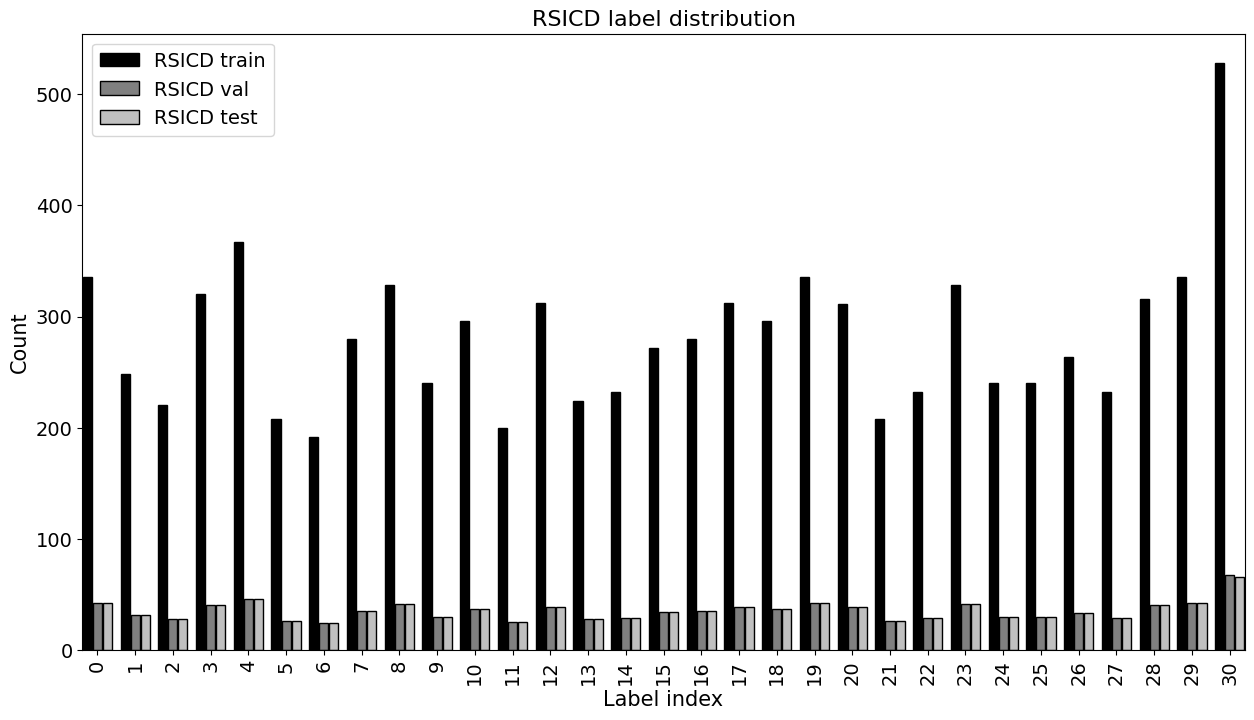

Sum train: 8734
Sum val: 1094
Sum test: 1093


In [5]:
# From: https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped
def bar_plot_multiple(ax, data, colors=None, total_width=0.8, single_width=1, legend=True, font_size = 12):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data to plot. Keys = the names of the data, items = a list of the values.

        Example: data = {"x":[1,2,3], "y":[1,2,3], "z":[1,2,3]}

    colors : array-like, optional, default: None
        A list of colors to use for the bars. If None, the colors are the standard matplotlib color cyle. 

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars will touch each other 
        within a group, values less than 1 will make these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """
    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []
    heights_left_bar = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x+x_offset, y, width=bar_width*single_width, color=colors[i % len(colors)], edgecolor = "black")
            height = bar[0].get_height()
            width = bar[0].get_width()
            loc = bar[0].get_x()
            
            if i % 3 == 0:
                heights_left_bar.append(height)

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
        
    # Draw legend if legend = True
    if legend:
        ax.legend(bars, data.keys(), fontsize = font_size, loc = 'upper left')
        
        
data = {
    # 'RSICD total': all_counts,
    'RSICD train': rsicd_train_counts, #/rsicd_all_counts*100, 
    'RSICD val': rsicd_val_counts, #/rsicd_all_counts*100,
    'RSICD test': rsicd_test_counts, #/rsicd_all_counts*100,
}

# Resize figure, choose fontsize 
fig, ax = plt.subplots(figsize=(15, 8))
font_size = 14

# Plot the bars and significances
bar_plot_multiple(ax, data, total_width=.8, single_width=0.9, colors = ['black', 'gray', 'silver', 'white'], font_size = font_size )


# Add text to the plot
plt.title('RSICD label distribution', fontsize = font_size + 2)
plt.xticks(range(rsicd_train_labels.shape[0]), rsicd_train_labels, rotation = 90, fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.ylabel('Count', fontsize = font_size+1)
plt.xlabel('Label index', fontsize = font_size+1)
plt.xlim(min(rsicd_train_labels)-0.4, max(rsicd_train_labels)+0.4)

# Store the plot as a .png
# plt.savefig('./results/FPs_distance_property.png', bbox_inches = 'tight')
plt.show()

print('Sum train:', np.sum(rsicd_train_counts))
print('Sum val:', np.sum(rsicd_val_counts))
print('Sum test:', np.sum(rsicd_test_counts))

In [6]:
# split_classes = []
# for d in data:
#     split_classes.append(path2class[d['filename']])
# Counter(split_classes)

In [7]:
path = './data/UCMerced_LandUse/Images'
num_images_in_folders = []
ucm_cls_paths = []
ucm_cls_images = []
for folder in os.listdir(path):
    print(folder)
    contents = os.listdir(os.path.join(path, folder))
    num_images_in_folders.append(len(contents))
    for img_name in contents:
        img = Image.open(os.path.join(path, folder, img_name))
        img = np.array(img.resize((256,256)))
        ucm_cls_images.append(img)
        ucm_cls_paths.append(folder)
print(num_images_in_folders)
ucm_cls_images = np.stack(ucm_cls_images)
print(ucm_cls_images.shape)

agricultural
airplane
baseballdiamond
beach
buildings
chaparral
denseresidential
forest
freeway
golfcourse
harbor
intersection
mediumresidential
mobilehomepark
overpass
parkinglot
river
runway
sparseresidential
storagetanks
tenniscourt
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
(2100, 256, 256, 3)


In [8]:
path = './data/UCM/dataset.json'
train = load_captions(path, 'train')
val = load_captions(path, 'val')
test = load_captions(path, 'test')
all = load_captions(path, '')
splits = [train, val, test]
for split in splits:
    print(len(split)/len(all))

0.8
0.1
0.1


In [ ]:
ucm_images_path = './data/UCM/images'
ucm_images = []
ucm_paths = []
for img_name in sorted(os.listdir(ucm_images_path), key = lambda x: int(x.split('.')[0])):
    img = Image.open(os.path.join(ucm_images_path, img_name))
    img_np = np.array(img)
    ucm_images.append(img_np)
    ucm_paths.append(img_name)
ucm_images = np.stack(ucm_images)
print(ucm_images.shape)

In [ ]:
ucm_to_cls_mappings = dict(zip(ucm_paths, ucm_cls_paths))
write_json('./data/UCMerced_LandUse/caption_to_cls_mapping.json', ucm_to_cls_mappings)

In [ ]:
num_comparisons = 15
fig, ax = plt.subplots(num_comparisons, 2, figsize=(5,16))
for i, idx in enumerate(np.random.choice(np.arange(ucm_images.shape[0]), size = num_comparisons, replace = False)):
    ax[i][0].imshow(ucm_images[idx])
    ax[i][1].imshow(ucm_cls_images[idx])
    ax[i][0].set_title('{} (captions data)'.format(idx))
    ax[i][1].set_title('{} (classif data)'.format(idx))
    ax[i][0].axis('off')
    ax[i][1].axis('off')
plt.suptitle('Comparing UCM images at the same index (captions vs classif data versions)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import copy
# dist_2 = copy.deepcopy(dist)
# np.fill_diagonal(dist_2, 1)
# min = np.argmin(dist_2, axis = 1).tolist()
# len(min), len(set(min))

In [ ]:
# path = './data/UCMerced_LandUse/Images'
# num_images_in_folders = []
# ucm_cls_images = []
# i = 0
# idx = 0
# for folder in os.listdir(path):
#     contents = os.listdir(os.path.join(path, folder))
#     num_images_in_folders.append(len(contents))
#     for img_name in contents:
#         img = Image.open(os.path.join(path, folder, img_name))
#         img = img.resize((256,256))
#         plt.imshow(img)
#         plt.title(idx)
#         plt.show()
#         i+=1
#         idx +=1
#         if i >= 5:
#             i = 0
#             break

# ucm_images_path = './data/UCM/images'
# ucm_images = []
# i = 0
# idx = 0
# for img_name in sorted(os.listdir(ucm_images_path), key = lambda x: int(x.split('.')[0])):
#     i+=1
#     if i > 5:
#         break
#     img = Image.open(os.path.join(ucm_images_path, img_name))
#     plt.imshow(img)
#     plt.title(i-1)
#     plt.show()
    
#     # if i >= 10:
#     #     break

In [ ]:
# %%time
# dist = np.abs(ucm_images-ucm_cls_images)
# np.fill_diagonal(dist, 1)
# min = np.min(dist, axis = 1)

In [ ]:
path = './data/sydney_captions/dataset.json'
train = load_captions(path, 'train')
val = load_captions(path, 'val')
test = load_captions(path, 'test')
all = load_captions(path, '')
splits = [train, val, test]
for split in splits:
    print(len(split))
    print(round(len(split)/len(all),2))
# read_json(path)
# print(os.listdir(path+'/images'))

In [ ]:
# I want to probably get the dict['items'] values for each folder and then take the images from there.
working_datasets = [] #['RSICD', 'UCM', 'Sydney', 'Fashion200k', 'SciCap', 'RSICD-CLS', 'UCM-CLS', 'Fashion200k-CLS', 'WHU-RS19', 'RSSCN7', 
                    #'AID', 'RESISC45', 'Simpsons-Images', 'Polyvore', 'Polyvore-CLS', 'FashionGen', 'FashionGen-CLS']
# get_custom_data(args, data, preprocess_fn, is_train, cls, subclass, **data_kwargs):
for dataset in working_datasets:
    print(dataset)
    cls = 'CLS' in dataset
    # CLS version of most datasets just uses the non-CLS dataloader, but adds cls = True as argument
    if dataset != 'UCM-CLS': # Exception: UCM-CLS is a different dataloader altogether than UCM!
        dataset = dataset.replace('-CLS', '')
    get_custom_data(None, data = dataset, preprocess_fn = None, is_train = True,)